<img src="./logo_UTN.svg" align="right" width="150">

# Tarea Semanal 5

### Autor: Tobías Guerrero

## Consigna

Se pide diseñar un filtro pasabanda que cumpla con la siguiente plantilla:

- $\omega_{0} = 2\pi\cdot22kHz$
- $Q = 5$
- Aproximación Chebyshev con ripple de 0,5dB

También se sabe que la transferencia del filtro debe ser:

- $|T(f_{S1})| = -16dB$ para $f_{S1} = 17kHz$
- $|T(f_{S2})| = -24dB$ para $f_{S2} = 36kHz$

<img src="./consigna.png">

## 1. Obtención de la transferencia

La transferencia para el filtro pedido se obtuvo mediante un desarrollo analítico en papel, para luego ser corroborada en una simulación mediante Python. Ambos procesos se detallan a continuación.
El resultado obtenido fue:

$\large T_{s} = \frac{s\cdot2,62}{s^{2} + 0,0682\cdot s + 1,227} \frac{s\cdot1,41}{s^{2} + 0,1268\cdot s + 1} \frac{s\cdot3,22}{s^{2} + 0,0556\cdot s + 0,814}$

### 1.1 Desarrollo en papel

<img src="./pag1.jpg">
<img src="./pag2.jpg">
<img src="./pag3.jpg">

### 1.2 Simulación numérica

Primero, se generaron las variables en función del prototipo pasabajos hallado previamente en papel.

In [1]:
#Librerías necesarias para la simulación
import scipy.signal as sig
import math
from pytc2.sistemas_lineales import tf2sos_analog,pretty_print_SOS,pretty_print_lti,analyze_sys

amax = 0.5
amin = 24
omega_stop = 2.64
Q = 5

Luego, se calcula el orden a través de la fórmula aproximada para una aproximación de Chebyshev, al cual luego se le aplica la función techo, para así tomar como orden el entero superior inmediato.

In [2]:
n_calc = (math.log(math.sqrt(4*((10**(0.1*amin) - 1)/(10**(0.1*amax) - 1)))))/(math.log(omega_stop+(math.sqrt((omega_stop**2)-1))))

n = math.ceil(n_calc)

ee = 10**(0.1*amax) - 1

Se hallan los polos y ceros en función de los parámetros, a través de los cuales se hayan el numerador y el denominador de la transferencia.

In [3]:
z,p,k = sig.cheb1ap(n,amax)
num, den = sig.zpk2tf(z,p,k)

tf = sig.TransferFunction(num, den)
pretty_print_lti(tf)

<IPython.core.display.Math object>

Se puede observar que tanto el numerador como el denominador coinciden con lo hallado en papel.

Posteriormente, se convirtió el prototipo pasabajos al objetivo pasabanda mediante la correspondiente función de scipy. Esta transferencia se convirtió a secciones de segundo orden para su posterior implementación, además de para corroborar las secciones halladas en papel.
En este punto también se hallaron los polos de la función que se utilizaron en el desarrollo en papel.

In [4]:
num_bp, den_bp = sig.lp2bp( num , den , bw=1/Q )
z_bp , p_bp , k_bp = sig.tf2zpk( num_bp , den_bp )

tf_bp = sig.TransferFunction( num_bp , den_bp )

print(p_bp)

[-0.03450874+1.10691778j -0.03450874-1.10691778j -0.06264565+0.99803583j
 -0.06264565-0.99803583j -0.02813691+0.90253228j -0.02813691-0.90253228j]


In [5]:
pretty_print_lti(tf_bp)

<IPython.core.display.Math object>

Se observa que los coeficientes coinciden con la transferencia hallada en papel.

In [6]:
sos_bp = tf2sos_analog( num_bp , den_bp )
pretty_print_SOS(sos_bp)

<IPython.core.display.Math object>

Nuevamente, se observa que las secciones de segundo orden coinciden con las halladas en papel, con una salvedad: los numeradores. Esto sucede porque la forma de asignar las ganancias a cada etapa que tiene la función $\textit{tf2sos_analog()}$ no es la misma que se adoptó para realizarlo en papel. Sin embargo, en ambos casos la multiplicación de los tres numeradores da como resultado el numerador de la función completa hallada en la sección de código anterior.

A partir del sistema hallado, se realizaron los gráficos utilizando la función $\textit{analyze_sys()}$ para corroborar que lo hallado se corresponda al filtro pedido.

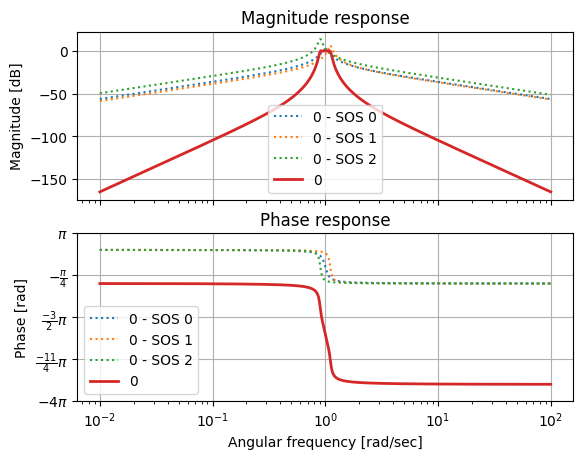

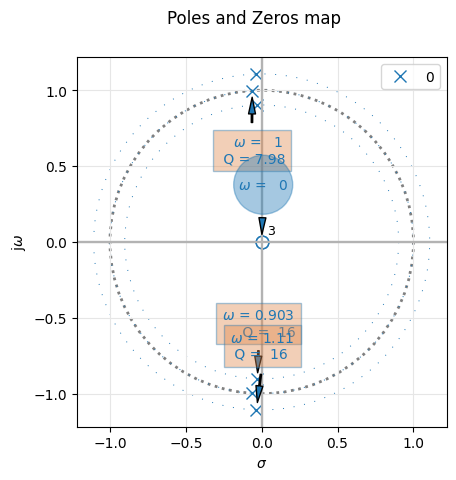

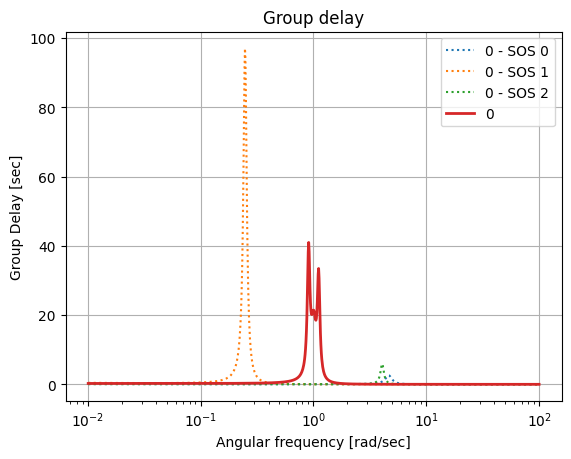

In [7]:
analyze_sys(sos_bp)

A partir de los gráficos de módulo y fase, queda en evidencia que la transferencia hallada se corresponde con el filtro pedido, normalizado en frecuencia.

## 2. Implementación pasiva

### 2.1 Topología elegida

A partir de la transferencia hallada, se propone la utilización del siguiente circuito para la implementación de cada sección de segundo orden:

<img src="implementacion.png" align="center">

Se eligió esta implementación para que luego sea más sencilla la inclusión de un GIC en lugar del inductor en el punto 3. 

Los parámetros de esta topología serán:

- $\omega_{0} = \frac{1}{\sqrt{LC}}$
- $\frac{\omega_{0}}{Q} = \frac{1}{RC}$ 
- $K = 1 + \frac{R_{1}}{R}$

Para cada sección, los valores de los componentes, normalizados en frecuencia y en impedancia, serán:

- Sección 1:
    - $R = 1$
    - $C = 7,886$
    - $L = 0,1268$
    - $R_{1} = 0,41$
    
- Sección 2:
    - $R = 1$
    - $C = 14,663$
    - $L = 0,00556$
    - $R_{1} = 1,62$
    
- Sección 3:
    - $R = 1$
    - $C = 17,986$
    - $L = 0,0683$
    - $R_{1} = 2,22$
    
### 2.2 Circuito final y resultados

El circuito final resulta:

<img src="circuito.png" align="center">

La simulación de este cicruito ofreció el siguiente resultado:

<img src="sim.png" align="center">

<img src="sim_zoom.png" align="center">

## 3. Implementación activa

Se propone ahora activar las redes pasivas mediante el siguiente circuito:

<img src="activa.png" align="center">


### 3.1 Análisis del circuito

Este circuito es un caso particular del circuito de la figura 5.16 del libro $\textit{Design of Analog Filters}$ de Schaumann y Van Vankelburg, el cual se incluye a continuación.

<img src="activa_schaumann.png" align="center">

En el caso presentado, no se cuenta con el capacitor de valor $\textit{aC}$ ni con el resistor de valor $\textit{R/c}$, lo cual indica que $a = c = 0$. Esto también puede observarse mediante la transferencia, la cual es:

$\large T_{(s)} = \frac{s^{2}\cdot(2a-c) + s\cdot\frac{\omega_{0}}{Q}\cdot(2b-c) + c\cdot(\omega_{0})^{2}}{s^{2} + s\cdot\frac{\omega_{0}}{Q} + (\omega_{0})^{2}}$

Aquí, se observa que para realizar una transferencia pasabanda, como la que se busca, se necesita que se anulen los términos cuadrático e independiente del numerador, lo cual se consigue con $a = c = 0$.

La transferencia entonces resulta:

$\large T_{(s)} = \frac{s\cdot\frac{\omega_{0}}{Q}\cdot2b}{s^{2} + s\cdot\frac{\omega_{0}}{Q} + (\omega_{0})^{2}}$

De donde se obtienen las siguientes ecuaciones de diseño:

- $R_{1} = R_{3} = R_{4} = R_{5} = R$
- $C_{1} = C_{2} = C$
- $\omega_{0} = \frac{1}{RC}$
- $R_{b} = \frac{Q\cdot R}{b}$
- $R_{c} = \frac{Q\cdot R}{1-b}$
- $K = 2b\cdot K^{'}$

Se incorporó en la fórmula de la ganancia K un término K' debido a que la ganancia que se logra con el levantamiento de masas realizado con $R_{b}$ y $R_{c}$ será siempre menor a 2 (debido al factor 2 que multiplica a b en la transferencia). En los casos en los que se necesite una ganancia mayor a 2, se incorporará una ganancia K' mediante un amplificador no inversor.

### 3.2 Diseño

Teniendo en cuenta las consideraciones realizadas en el punto anterior, se obtuvieron los siguientes valores de componentes, normalizados en frecuencia y en impedancia:

- Sección 1: Se diseñó un no inversor con una ganancia de 2, de forma que $2b = 1,31$
    - $C = 1$
    - $R = 0,9$
    - $R_{b} = 22,38$
    - $R_{c} = 42,49$
    
- Sección 2: Debido a que la ganancia de la etapa es $1,61 < 2$, no fue necesario incorporar ganancia adicional. Además, como la salida de la etapa anterior es mediante un amplificador operacional, no se incorporó una etapa separadora. 
    - $C = 1$
    - $R = 1$
    - $R_{b} = 11,19$
    - $R_{c} = 26,74$
    
- Sección 1: Se diseñó un no inversor con una ganancia de 2, de forma que $2b = 1,61$
    - $C = 1$
    - $R = 1,11$
    - $R_{b} = 20,15$
    - $R_{c} = 83,18$
    
### 3.3 Circuito final y resultados

El circuito final resulta: 

<img src="completo_GIC.png" align="center">

Con este circuito, se obtuvo el siguiente resultado:

<img src="sim_GIC.png" align="center">

<img src="sim_GIC_zoom.png" align="center">

## 4. Factor de calidad de los componentes

Al realizar las primeras simulaciones de la implementación pasiva, se encontró que la transferencia no se correspondía con la de un equiripple; había una diferencia no despreciable entre los picos derecho e izquierdo en la banda de paso respecto a lo calculado. En concreto, se observaba una atenuación.

<img src="at.png" align="center">

Realizando distintas pruebas para descubrir el motivo de este error, se descubrió que el problema provenía del Q de las secciones: al calcularlo como $\frac{\omega_{0}}{BW}$ (midiendo el ancho de banda con la simulación), el resultado obtenido era menor a lo buscado.
Luego de un tiempo de investigar el motivo del error, y con ayuda de los profesores, se llegó a la conclusión de que el problema aparecía debido al factor de calidad de los componentes reactivos (capacitor e inductor), también llamado Q. 
El programa utilizado para la simulación, LTSpice, asigna un valor no nulo a las resistencias parásitas de los componentes reactivos. Este valor es pequeño, al punto que en implementaciones de bajo Q no llega a apreciarse la diferencia. Sin embargo, al buscar implementar circuitos de alto Q, como es este caso (donde el menor Q que se tiene es de aproximadamente 8), el factor de calidad de los componentes empieza a tener efectos en la transferencia. Esto sucede porque no se puede implementar un circuito con elementos cuyo Q sea menor al buscado según la transferencia.
Entendido esto, se procedió a quitar las resistencias parásitas de los capacitores (colocando 0 en todas ellas), y a seleccionar la opción en el panel de control que permite asignar una resistencia parásita nula a todos los inductores. Una vez hecho esto, los resultados obtenidos fueron los que se obtuvieron en los apartados anteriores.

<img src="conf_cap.png" align="center">
<img src="conf_inductor.png" align="center">

### 5. Conclusiones

Como conclusión principal, puede afirmarse que el filtro solicitado pudo ser diseñado, cumpliendo con los requisitos preestablecidos.
En la realización de este trabajo se descubrió además el efecto que tienen las no idealidades de los componentes. Si bien las simulaciones realizadas fueron en condiciones ideales, y se entiende que no es el alcance diseñar teniéndolas en cuenta, es importante considerarlas, sobre todo a la hora de diseñar filtros de alto Q.
Por otro lado, se observa que la transferencia realizada en la simulación no es exactamente equiripple. Esto puede atribuirse a las no idealidades en este caso de los amplificadores operacionales, que son los encargados de generar la ganancia necesaria para llegar al equiripple. Esto podría justificarse matemáticamente realizando un análisis de sensibilidad de la ganancia de cada etapa en función de los dispositivos. Resulta interesante destacar que, en este sentido, la implementación pasiva es más fiable, como se observa en las simulaciones, aunque también tecnológicamente más compleja.
Por último, se encontró una gran importancia en el método de levantamiento de masas y en la implementación mediante redes bicuadráticas. Estas últimas resultan de gran ayuda debido a la versatilidad que ofrece poder realizar distintos tipos de filtros variando el valor de algunos componentes.

### Bibliografía

Schaumann, M.  Van Valkenburg, M.E, (2001). 5. Second-Order Filters With Arbitrary Transmission Zeros en *Design of Analog Filters* (1 ed., pp. 192–251). Oxford University Press.